# SME0104 - Avaliação Prática 1
## Aluno: Eduardo Rodrigues Amaral
## NUSP: 11735021

### Importando bibliotecas necessárias

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
from datetime import datetime, timedelta

### Baixando os dados necessários

In [2]:
!rm -rf data
!mkdir data
!wget https://raw.githubusercontent.com/rolimans/sme0104-pt2/main/data/casosacumuladosbrasilatuaizado.txt -O data/casosacumuladosbrasilatuaizado.txt -q
!wget https://raw.githubusercontent.com/rolimans/sme0104-pt2/main/data/image.jpg -O data/image.jpg -q

## 1 Decomposição em Valores Singulares (SVD)

A decomposição SVD de uma matriz $A_{m×n}$ tem a forma

$$A = UΣV^T$$

em que $U$ é uma matriz $m × n$ ortogonal, $V$ uma matriz também ortogonal com dimensão $n × n$ e $Σ$ uma matriz diagonal $m × n$ com entradas

$$ σ_{ij} = \begin{cases}
  0 \text{ para } i \neq j \\
  \sigma \geq 0 \text{ para }  i = j
 \end{cases}  $$

Esses valores $σ_i$ são chamados de valores singulares de $A$ e geralmente são ordenados tais que $σ_{i−1} ≥ σ_i$ , $i =
2, · · · , min\{m, n\}$. Já as colunas de $U$ e $V$ são os vetores singulares a esquerda e a direita, respectivamente.

Esta decomposição está diretamente ligada a algoritmos para calcular autovalores e autovetores de matrizes. Os
valores singulares de $A$ são as raı́zes quadradas dos autovalores de $A^TA$ e as colunas $U$ e $V$ são os autovetores ortonormais de $AA^T$ e $A^TA$ respectivamente.

Ainda, para uma matriz simétrica $B_{n×n}$ , a decomposição QR pode ser usada para calcular **todos** os seus autovalores e autovetores usado sucessivas decomposições até que se obtenha uma matriz diagonal (ou muito próxima de uma diagonal). O processo envolvido é

1. $B_1 = B$ decompõe-se a matriz $B_1 = Q_1 R_1$
2. $B_2 = R_1 Q_1$ decompõe-se a matriz $B_2 = Q_2 R_2$
3. $B_3 = R_2 Q_2$ e então $_3 = Q_3 R_3$
4. Repete-se essas iterações até $B_k = R_{k−1} Q_{k−1 }$

como trata-se de um processo iterativo, é importante escolher um bom critério de parada. Dentre os critérios mais usados, pode-se limitar o número de iterações $k$ por um máximo de iterações $k_{max}$, verificar se os elementos da matriz fora da diagonal estão tão próximos de zero quanto se queira usando uma tolerância

$$ max_{i<j} \{|b_{ij} |\} < ϵ $$

ou verificar se $off(B) < ϵ $ em que

$$ off(B) = \sqrt{|| B ||^2_F - \sum_{i=1}^{n}{b^2_{ii}}} $$

Este método é conhecido como método de Francis, ao final do processo iterativo, tem-se

$$ B_k = V^TBV $$

em que $V = Q_1 Q_2 · · · Q_{k−1}$ , ou seja, $B$ e $B_k$ são matrizes semelhantes e possuem os mesmos autovalores. Além disso, $B_k$, como dito anteriormente, converge para uma matriz diagonal, ou seja, os elementos da diagonal de Bk fornecem uma aproximação para os autovalores de $B$ e as colunas das matriz $V = Q_1 Q_2 · · · Q_{k−1}$ são aproximações dos respectivos autovetores.

O método de Francis pode ser usado para obter a decomposição SVD de uma matriz qualquer $A_{m×n}$ ao ser aplicado nas matrizes simétricas $AA^T$ e $A^TA$, uma vez que

*   $AA^T = (UΣV^T)(UΣV^T)^T = UΣ(V^TV)ΣU^T = UΣ^2U^T$ e
*   $A^TA = (UΣV^T)^T (UΣV^T) = VΣ(U^TU)ΣV^T = VΣ^2V^T$ .


### a)
Escreva um código implementando o método de Francis usando a função *numpy.linalg.qr* para obter as decomposições QR necessárias.

In [3]:
def francisMethod(B, tol=1e-10, maxK=1e8):
  n = len(B)
  In = np.eye(n)
  V = In.copy()

  for k in range(int(maxK)):
    Q, R = np.linalg.qr(B)

    V = np.dot(V, Q)
    B = np.dot(R, Q)

    # Evite usar np.sqrt(np.linalg.norm(B)**2 - np.sum(np.diagonal(B)**2))
    # Numericamente instável, valor dentro da raiz pode resultar negativo
    # Use o seguinte código, que calcula a norma de B sem as diagonais (equivalente)

    offB = np.linalg.norm(B - (In * np.diagonal(B)))

    if offB < tol:
      break

  eigVals = np.diagonal(B)
  eigVecs = V

  return eigVals, eigVecs

# Gera uma matriz simétrica A aleatória
np.random.seed(42)

A = np.random.rand(5,5).astype(np.float64)

A = (A + A.T) / 2.

eigVals, eigVecs = francisMethod(A)

# Ordena os autovalores e autovetores por autovalor de forma ascendente
orderedIdx = np.flip(eigVals.argsort()[::-1])
eigVals = eigVals[orderedIdx]
eigVecs = eigVecs[:,orderedIdx]

# Função já retorna valores ordenados
eigValsTest, eigVecsTest = np.linalg.eigh(A)

print(f'Os autovalores calculados pelo método de Francis estão corretos? {np.allclose(eigVals, eigValsTest, atol=1e-23)}')
print(f'Os autovetores calculados pelo método de Francis estão corretos? {np.allclose(np.abs(eigVecs), np.abs(eigVecsTest), atol=1e-23)}')

Os autovalores calculados pelo método de Francis estão corretos? True
Os autovetores calculados pelo método de Francis estão corretos? True


### b)

Usando a rotina implementada para o método de Francis, escreva um código que retorne a decomposição SVD de uma matriz qualquer $A{m×n}$.

In [4]:
def svdWithFrancis(A, tol=1e-10, maxK=1e8):

  m,n = A.shape

  # Ao verificar a dimensão da matriz e aproveitar as relações de A = UΣV^T é possível calcular U, Σ e V^T
  # com apenas uma chamada ao método de Francis
  if m > n:
    # AA^T = (UΣV^T)(UΣV^T)^T = UΣ(V^TV)ΣU^T = UΣ^2U^T
    S, U = francisMethod(np.dot(A,A.T), tol, maxK)
    S = np.sqrt(S[:-(m-n)])

    # A = U Σ V^T => V^T = Σ^-1 U^-1 A  => V^T = Σ^-1 U^T A
    Vh = np.dot(np.dot(np.diag(1/S),U.T[:-(m-n)]), A)
  elif m < n:
    # A^TA = (UΣV^T)^T (UΣV^T) = VΣ(U^TU)ΣV^T = VΣ^2V^T
    S, V = francisMethod(np.dot(A.T,A), tol, maxK)
    # print(S)
    S = np.sqrt(S[:-(n-m)])

    # A = U Σ V^T => U = A V Σ^-1
    U = np.dot(np.dot(A,V)[:,:-(n-m)], np.diag(1/S))

    Vh = V.T
  else:
    # AA^T = (UΣV^T)(UΣV^T)^T = UΣ(V^TV)ΣU^T = UΣ^2U^T
    S, U = francisMethod(np.dot(A,A.T), tol, maxK)
    S = np.sqrt(S)

    # A = U Σ V^T => V^T = Σ^-1 U^-1 A  => V^T = Σ^-1 U^T A
    Vh = np.dot(np.dot(np.diag(1/S),U.T), A)

  return U, S, Vh

np.random.seed(42)

shapes = ((5,7), (7,5),(7,7))

for shape in shapes:

  m,n = shape

  A = np.random.rand(m,n).astype(np.float64)

  U, S, Vh = svdWithFrancis(A)

  fullS = np.diag(S)

  if m>n:
    fullS = np.vstack([fullS, np.zeros((m-n,n))])
  elif n>m:
    fullS = np.hstack([fullS, np.zeros((m,n-m))])

  ATest = np.dot(np.dot(U, fullS), Vh)

  print(f"Teste com matriz {shape}")

  print(f'A = U * Σ * V^T utilizando o SVD com o método de Francis? {np.allclose(A, ATest, atol=1e-23)}')

Teste com matriz (5, 7)
A = U * Σ * V^T utilizando o SVD com o método de Francis? True
Teste com matriz (7, 5)
A = U * Σ * V^T utilizando o SVD com o método de Francis? True
Teste com matriz (7, 7)
A = U * Σ * V^T utilizando o SVD com o método de Francis? True


###  c)

Podemos armazenar uma imagem em uma matriz $A_{m×n}$. Toda imagem consiste em um conjunto de pixels que são os blocos de construção dessa imagem. Cada pixel representa a cor ou a intensidade da luz em um local especı́fico na imagem. Em uma imagem em escala de cinza em formato PNG, cada pixel tem um valor entre 0 e 1, em que 0 corresponde ao preto e 1 corresponde ao branco. Assim, uma imagem em escala de cinza com $m × n$ pixels pode ser armazenada em uma matriz $m × n$ com valores entre 0 e 1. Use a função *imread()* da biblioteca Matplotlib do Python para carregar uma imagem de uma foto pessoal em escala de cinza. Depois, use as decomposições SVD *numpy.linalg.svd* e a implementada no item 2) para comprimir a imagem, representando-a por $k(k < min\{m, n\})$ valores singulares, isto é, troque a matriz $A$ por $A_k = U[:,:k] ∗ Σ[: k, : k] ∗ V^T [: k, :]$.

Plote a imagem original e a imagem 50% e 70% comprimida e compare os resultados. Para tal, use a função *imshow()*, também da biblioteca Matplotlib.

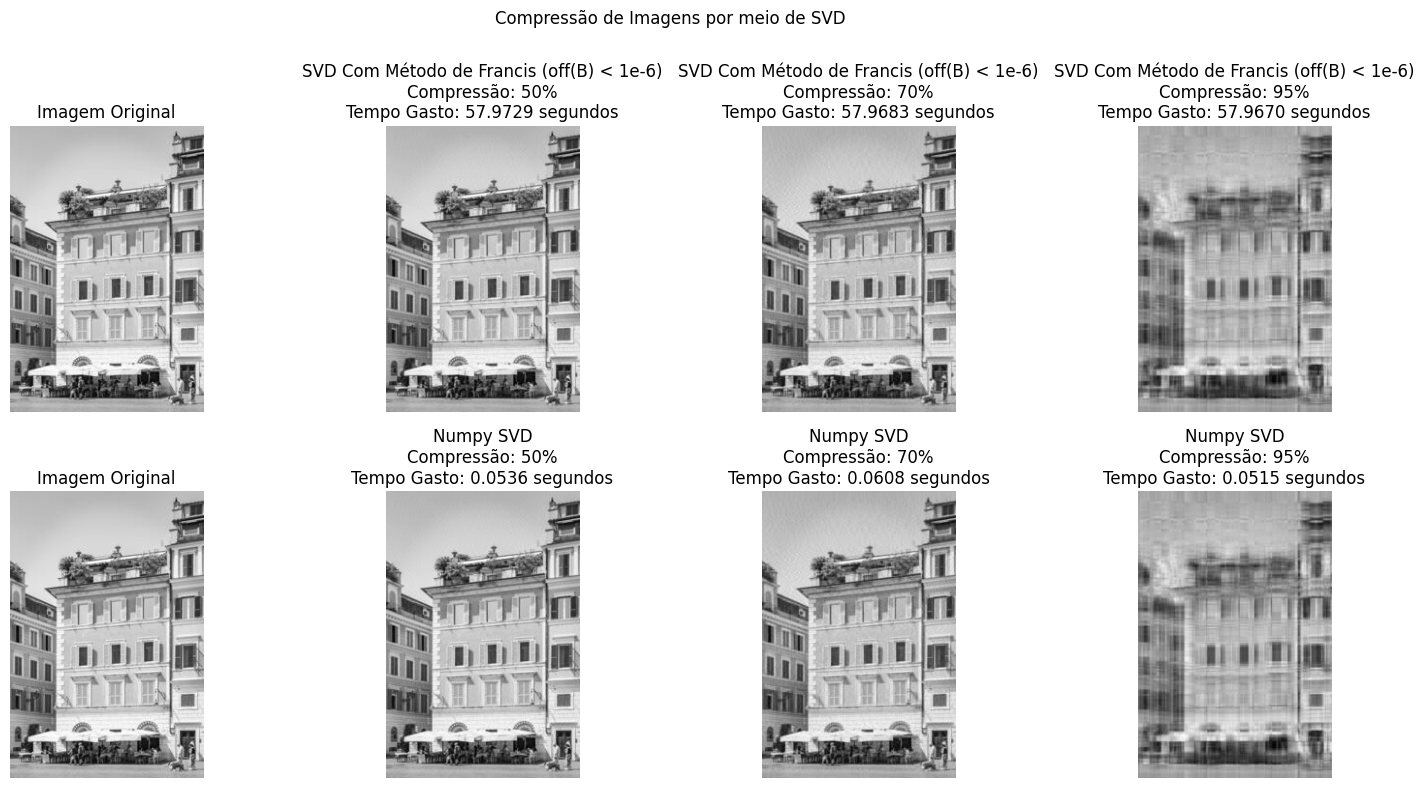

In [5]:
originalImage = (np.array(plt.imread("data/image.jpg"))/255).astype(np.float64)

compressionRates = (None, 50, 70, 95)
algorithms = (('SVD Com Método de Francis (off(B) < 1e-6)', lambda A: svdWithFrancis(A,tol=1e-6)) , ("Numpy SVD", np.linalg.svd))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, (name, func) in enumerate(algorithms):

  startSvd = time.time()

  U, S, Vh = func(originalImage)

  endSvd = time.time()

  elapsedTimeSvd = endSvd - startSvd

  for j, compressionRate in enumerate(compressionRates):

    if compressionRate is None:
      image = originalImage
      title = "Imagem Original"
    else:
      startSlice = time.time()

      k = int(min(originalImage.shape) * (1 - (compressionRate/100)))

      image = np.dot(np.dot(U[:,:k], np.diag(S)[:k,:k]), Vh[:k,:])

      endSlice = time.time()

      elapsedTime = elapsedTimeSvd + (endSlice - startSlice)

      title = f"{name}\nCompressão: {compressionRate}%\nTempo Gasto: {elapsedTime:.4f} segundos"

    axes[i, j].imshow(image, cmap='gray')
    axes[i, j].set_title(title)
    axes[i, j].axis("off")

plt.suptitle("Compressão de Imagens por meio de SVD\n")
plt.tight_layout()
plt.show()

Ambos os métodos alcançam resultados satisfatórios, porém o método SVD implementado pela biblioteca *numpy* é significativamente mais rápido que o método SVD com método de Francis.

## 2 Interpolação

Para a função

$$ f(t) = \frac{1}{1 + 25t^2} $$

no intervalo $[-1,1]$ faça:

### a)

Implemente a interpolação de Lagrange e de Newton.

In [6]:
def lagrangeInterpolation(x, y):
  x = np.array(x)
  y = np.array(y)

  n = len(x)

  def f(x0):
    s = 0

    for i in range(n):
      p = 1

      for j in range(n):
        if i != j:
          # Calcula o coeficiente de Lagrange para este termo
          p *= (x0 - x[j]) / (x[i] - x[j])

      # Adiciona este termo à soma
      s += y[i] * p

    return s

  return np.vectorize(f)

def newtonInterpolation(x, y):
  x = np.array(x)
  y = np.array(y)

  n = len(x)

  a = y.copy()

  # Calcula as diferenças divididas
  for j in range(1, n):
    for i in range(n-1, j-1, -1):
      a[i] = (a[i] - a[i-1]) / (x[i] - x[i-j])

  def f(x0):
    s = a[-1]
    # Calcula o valor interpolado utilizando multiplicação aninhada
    for i in range(n-2, -1, -1):
      s = a[i] + (x0 - x[i]) * s
    return s

  return np.vectorize(f)

### b)

Usando 11 pontos igualmente espaçados dentro do intervalo dado, calcule as interpolações de Lagrange e Newton com o código implementado no item anterior.

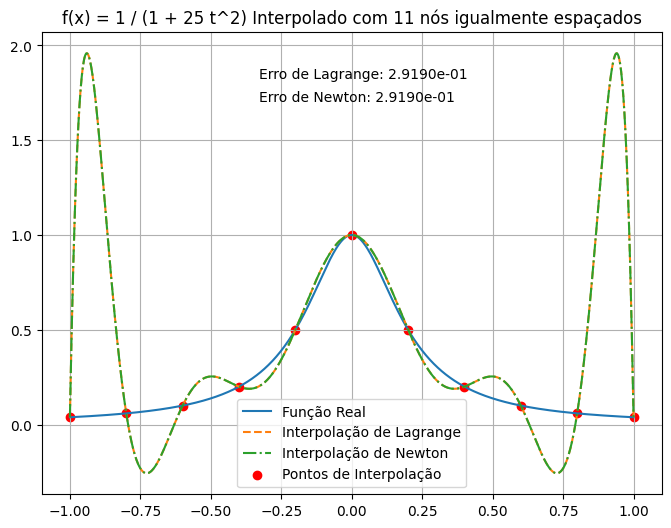

In [7]:
x = np.linspace(-1, 1, 11, dtype=np.float64)

f = np.vectorize(lambda x: 1/ (1 + 25 * (x**2)))

y = f(x)

lagrange = lagrangeInterpolation(x,y)

newton = newtonInterpolation(x,y)

nPlot = 1000
xPlot = np.linspace(-1,1,nPlot, dtype=np.float64)

yReal = f(xPlot)
yLagrange = lagrange(xPlot)
yNewton = newton(xPlot)

lagrangeErr = np.sum(np.abs(yReal-yLagrange)) / nPlot
newtonErr = np.sum(np.abs(yReal-yNewton)) / nPlot

plt.figure(figsize=(8, 6))

plt.plot(xPlot, yReal, label='Função Real')
plt.plot(xPlot, yLagrange, label='Interpolação de Lagrange', linestyle='dashed')
plt.plot(xPlot, yNewton, label='Interpolação de Newton', linestyle='dashdot')

plt.scatter(x, y, color='red', label='Pontos de Interpolação')

plt.title('f(x) = 1 / (1 + 25 t^2) Interpolado com 11 nós igualmente espaçados')
plt.legend()

plt.text(0.35, 0.9, f"Erro de Lagrange: {lagrangeErr:.4e}", transform=plt.gca().transAxes)
plt.text(0.35, 0.85, f"Erro de Newton: {newtonErr:.4e}", transform=plt.gca().transAxes)

plt.grid(True)
plt.show()

### c)
Repita o processo com 21 pontos. O que acontece? Exiba o gráfico das soluções comparando com a exata.

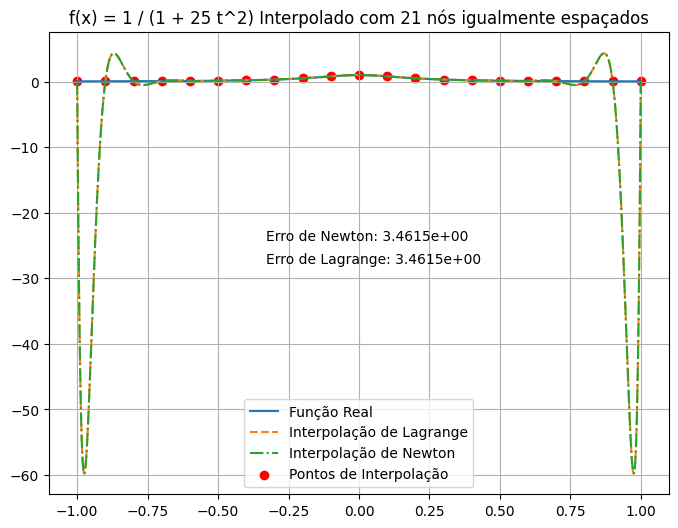

In [8]:
x = np.linspace(-1, 1, 21, dtype=np.float64)

f = np.vectorize(lambda x: 1/ (1 + 25 * (x**2)))

y = f(x)

lagrange = lagrangeInterpolation(x,y)

newton = newtonInterpolation(x,y)

nPlot = 1000
xPlot = np.linspace(-1,1,nPlot, dtype=np.float64)

yReal = f(xPlot)
yLagrange = lagrange(xPlot)
yNewton = newton(xPlot)

lagrangeErr = np.sum(np.abs(yReal-yLagrange)) / nPlot
newtonErr = np.sum(np.abs(yReal-yNewton)) / nPlot

plt.figure(figsize=(8, 6))

plt.plot(xPlot, yReal, label='Função Real')
plt.plot(xPlot, yLagrange, label='Interpolação de Lagrange', linestyle='dashed')
plt.plot(xPlot, yNewton, label='Interpolação de Newton', linestyle='dashdot')

plt.scatter(x, y, color='red', label='Pontos de Interpolação')

plt.title('f(x) = 1 / (1 + 25 t^2) Interpolado com 21 nós igualmente espaçados')
plt.legend()

plt.text(0.35, 0.5, f"Erro de Lagrange: {lagrangeErr:.4e}", transform=plt.gca().transAxes)
plt.text(0.35, 0.55, f"Erro de Newton: {newtonErr:.4e}", transform=plt.gca().transAxes)

plt.grid(True)
plt.show()

Ao aumentar o número de pontos a serem interpolados, as funções interpoladas divergem mais da função original, a área entre as funções interpoladas e a função original aumenta, logo o erro de ambas interpolações aumenta significativamente.

Tal fenômeno é chamado de Fenômeno de **Runge** que conclui que aumentar o grau do polinômio interpolado não garante convergência e que interpolações polinomiais de ordem alta são instáveis para pontos uniformemente espaçados.

### d)

Usando a função **scipy.interpolate.interp1d** calcule a interpolação usando *spline* linear e cúbica. Exiba
os gráficos e comente as diferenças das soluções deste item para os anteriores.

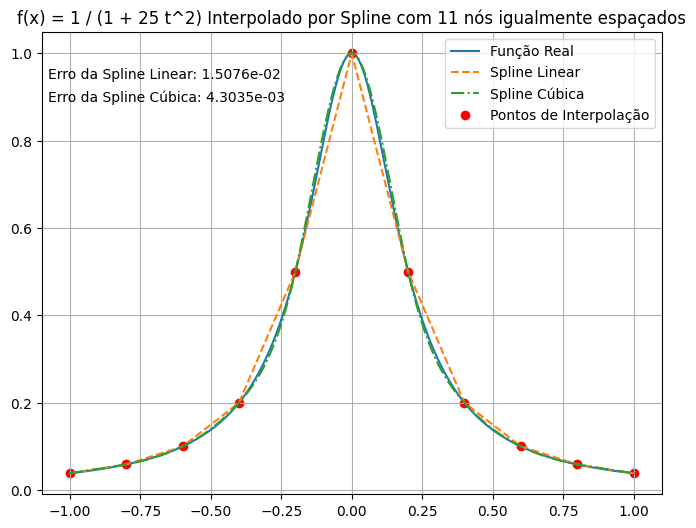

In [9]:
x = np.linspace(-1, 1, 11, dtype=np.float64)

f = np.vectorize(lambda x: 1/ (1 + 25 * (x**2)))

y = f(x)

linSpline = sp.interpolate.interp1d(x, y, kind='linear')

cubSpline = sp.interpolate.interp1d(x, y, kind='cubic')

nPlot = 1000
xPlot = np.linspace(-1,1, nPlot, dtype=np.float64)

yReal = f(xPlot)
yLinSpline = linSpline(xPlot)
yCubSpline = cubSpline(xPlot)

linSplineErr = np.sum(np.abs(yReal-yLinSpline))/nPlot
cubSplineErr = np.sum(np.abs(yReal-yCubSpline))/nPlot

plt.figure(figsize=(8, 6))

plt.plot(xPlot, yReal, label='Função Real')
plt.plot(xPlot, yLinSpline, label='Spline Linear', linestyle='dashed')
plt.plot(xPlot, yCubSpline, label='Spline Cúbica', linestyle='dashdot')

plt.scatter(x, y, color='red', label='Pontos de Interpolação')

plt.title('f(x) = 1 / (1 + 25 t^2) Interpolado por Spline com 11 nós igualmente espaçados')
plt.legend()

plt.text(0.01, 0.90, f"Erro da Spline Linear: {linSplineErr:.4e}", transform=plt.gca().transAxes)
plt.text(0.01, 0.85, f"Erro da Spline Cúbica: {cubSplineErr:.4e}", transform=plt.gca().transAxes)

plt.grid(True)
plt.show()

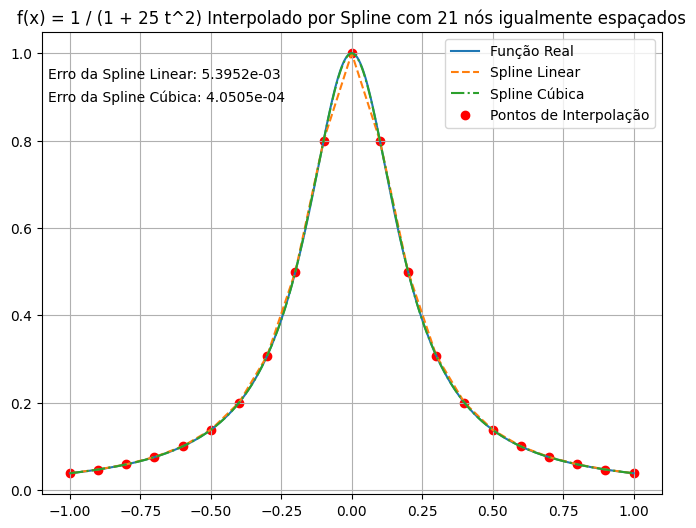

In [10]:
x = np.linspace(-1, 1, 21, dtype=np.float64)

f = np.vectorize(lambda x: 1/ (1 + 25 * (x**2)))

y = f(x)

linSpline = sp.interpolate.interp1d(x, y, kind='linear')

cubSpline = sp.interpolate.interp1d(x, y, kind='cubic')

nPlot = 1000
xPlot = np.linspace(-1,1, nPlot, dtype=np.float64)

yReal = f(xPlot)
yLinSpline = linSpline(xPlot)
yCubSpline = cubSpline(xPlot)

linSplineErr = np.sum(np.abs(yReal-yLinSpline))/nPlot
cubSplineErr = np.sum(np.abs(yReal-yCubSpline))/nPlot

plt.figure(figsize=(8, 6))

plt.plot(xPlot, yReal, label='Função Real')
plt.plot(xPlot, yLinSpline, label='Spline Linear', linestyle='dashed')
plt.plot(xPlot, yCubSpline, label='Spline Cúbica', linestyle='dashdot')

plt.scatter(x, y, color='red', label='Pontos de Interpolação')

plt.title('f(x) = 1 / (1 + 25 t^2) Interpolado por Spline com 21 nós igualmente espaçados')
plt.legend()

plt.text(0.01, 0.90, f"Erro da Spline Linear: {linSplineErr:.4e}", transform=plt.gca().transAxes)
plt.text(0.01, 0.85, f"Erro da Spline Cúbica: {cubSplineErr:.4e}", transform=plt.gca().transAxes)

plt.grid(True)
plt.show()

Ao interpolar com Splines, sejam elas cúbicas ou lineares, aproxima-se uma função (cúbica ou linear) para cada par de pontos. Como são utilizados polinômios de graus bem menores (1 e 3) do que os graus da intepolação de Lagrange e Newton, e interpola-se para intervalos menores (de dois em dois pontos), a aproximação não diverge tanto da função real e os erros são bem menores resultando em uma aproximação mais satisfatória.

Vale ressaltar também que as Splines cúbicas são capazes de expressar as curvas e suavidades da função original, enquanto as Splines lineares não. Por esse motivo, as Splines cúbicas são mais acuradas do que as lineares.

### e)

Repita os itens b) e c) com nós de Chebyshev.

In [11]:
def chebyshevNodes(start, end, n, dtype=np.float32):
    x = np.cos(np.pi * (2 * np.arange(1, n+1, dtype=dtype) - 1) / (2 * n))
    return (start + end) / 2 + (end - start) / 2 * x

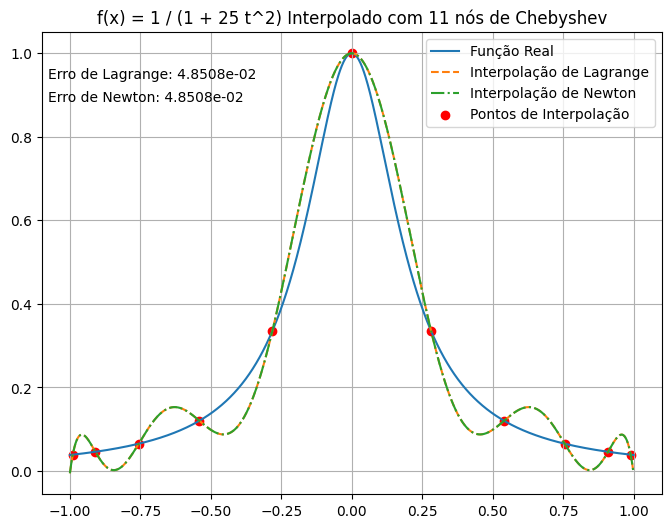

In [12]:
x = chebyshevNodes(-1, 1, 11, dtype=np.float64)

f = np.vectorize(lambda x: 1/ (1 + 25 * (x**2)))

y = f(x)

lagrange = lagrangeInterpolation(x,y)

newton = newtonInterpolation(x,y)

nPlot = 1000
xPlot = np.linspace(-1,1,nPlot, dtype=np.float64)

yReal = f(xPlot)
yLagrange = lagrange(xPlot)
yNewton = newton(xPlot)

lagrangeErr = np.sum(np.abs(yReal-yLagrange)) / nPlot
newtonErr = np.sum(np.abs(yReal-yNewton)) / nPlot

plt.figure(figsize=(8, 6))

plt.plot(xPlot, yReal, label='Função Real')
plt.plot(xPlot, yLagrange, label='Interpolação de Lagrange', linestyle='dashed')
plt.plot(xPlot, yNewton, label='Interpolação de Newton', linestyle='dashdot')

plt.scatter(x, y, color='red', label='Pontos de Interpolação')

plt.title('f(x) = 1 / (1 + 25 t^2) Interpolado com 11 nós de Chebyshev')
plt.legend()

plt.text(0.01, 0.9, f"Erro de Lagrange: {lagrangeErr:.4e}", transform=plt.gca().transAxes)
plt.text(0.01, 0.85, f"Erro de Newton: {newtonErr:.4e}", transform=plt.gca().transAxes)

plt.grid(True)
plt.show()

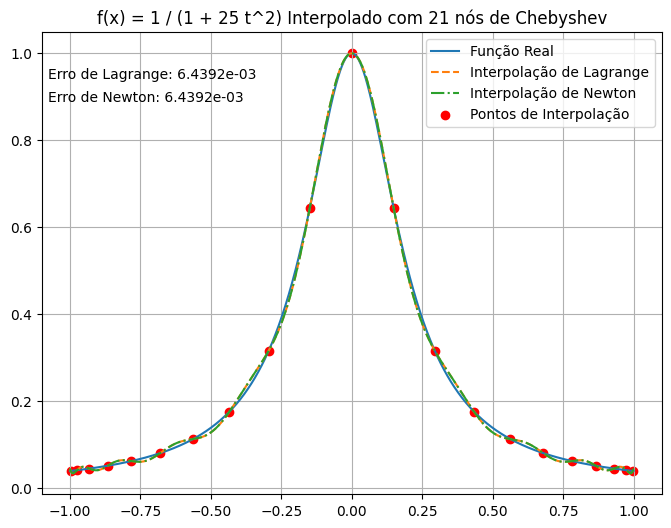

In [13]:
x = chebyshevNodes(-1, 1, 21, dtype=np.float64)

f = np.vectorize(lambda x: 1/ (1 + 25 * (x**2)))

y = f(x)

lagrange = lagrangeInterpolation(x,y)

newton = newtonInterpolation(x,y)

nPlot = 1000
xPlot = np.linspace(-1,1,nPlot, dtype=np.float64)

yReal = f(xPlot)
yLagrange = lagrange(xPlot)
yNewton = newton(xPlot)

lagrangeErr = np.sum(np.abs(yReal-yLagrange)) / nPlot
newtonErr = np.sum(np.abs(yReal-yNewton)) / nPlot

plt.figure(figsize=(8, 6))

plt.plot(xPlot, yReal, label='Função Real')
plt.plot(xPlot, yLagrange, label='Interpolação de Lagrange', linestyle='dashed')
plt.plot(xPlot, yNewton, label='Interpolação de Newton', linestyle='dashdot')

plt.scatter(x, y, color='red', label='Pontos de Interpolação')

plt.title('f(x) = 1 / (1 + 25 t^2) Interpolado com 21 nós de Chebyshev')
plt.legend()

plt.text(0.01, 0.9, f"Erro de Lagrange: {lagrangeErr:.4e}", transform=plt.gca().transAxes)
plt.text(0.01, 0.85, f"Erro de Newton: {newtonErr:.4e}", transform=plt.gca().transAxes)

plt.grid(True)
plt.show()

Ao interpolar com os nós de Chebyshev, os resultados obtidos são bem mais satisfatórios. As funções interpoladas aproximam melhor a função original. Vale ressaltar também que ao utilizar tais nós, o aumento de pontos a serem interpolados melhora a aproximação, ao invés de piorá-la como ocorria com pontos igualmente espaçados.

## 3 Mínimos Quadrados

Vamos supor que os casos acumulados de Covid-19, no período inicial da pandemia, de 26 de fevereiro de 2020 a 18 de junho de 2020 são dados em *casosacumuladosbrasilatualizado.txt*. O objetivo deste exercício é estudar o ajuste dos dados, no sentido dos mínimos quadrados, a uma função $g(x) = ab^x$, com $a, b ∈ R$.

Vamos utilizar os códigos implementados em aula:

In [14]:
def mmq(x, y, k):
  X = np.vander(x, k)
  A = np.transpose(X).dot(X)
  b = np.transpose(X).dot(y)
  a = np.linalg.solve(A,b)
  return a

def mmqQR(x, y, k):
  X = np.vander(x, k)
  (Q, R) = np.linalg.qr(X)
  b = np.transpose(Q).dot(y)
  a = np.linalg.solve(R, b)
  return a

### a)

Explique cada um dos códigos dados acima. O que está sendo calculado?

Ambas funções acima são implementações do método dos mínimos quadrados (MMQ) para ajustar um polinômio de grau $k$ aos pontos ($x,y$) dados.

A primeira função `mmq` utiliza uma abordagem tradicional de solução dos MMQ.

Utiliza-se o produto vetorial entre a transposta da matriz de *Vandermonde* para os dados $x$ e ela mesma (matriz de Gram) como a matriz $A$ de um sistema.

Já o vetor $b$ do sistema é obtido pelo produto vetorial entre a transposta de *Vandermonde* para os dados $x$ e vetor formado pelos dados $y$ (produtos internos dos $y$ com os elementos da base).

Soluciona-se o sistema dado por $ Ax = b$ e obtém-se os coeficientes do polinômio ajustado desejado no vetor $x$ solução do sistema.

$$
\\
$$

Já a segunda função `mmqQR` aproveita-se de propriedades da decomposição $QR$ para obter um sistema triangular superior de mais rápida solução para obtenção dos coeficientes do polinômio ajustado desejado.

O sistema original (utilizado pela função anterior) é dado por:

$$ X^TXα^* = X^Ty $$

Realizando a decomposição $QR$ em $X$ obtém-se:

$$ X=QR $$

Tendo em vista que $Q$ é uma matriz ortogonal e $R$ é uma matriz triangular superior, faz-se:
$$
X^TXα^* = X^Ty ⇔  (QR)^T(QR)α^* = (QR)^Ty \\
⇔ R^T (Q^T Q) R α^* = R^T Q^T y \\
⇔ R α^* = Q^T y
$$

Sendo assim a função `mmqQR` calcula a decomposição $QR$ da matriz de *Vandermonde* para os dados $x$. Calcula $b = Q^Ty$. E por fim soluciona o sistema triangular superior dado por $Rx = b$ de modo a obter os coeficientes do polinômio ajustado desejado no vetor $x$ solução do sistema.

### b)

Aproxime, no sentido dos mínimos quadrados, os dados do período completo, de 26 de fevereiro de 2020 a 18 de junho de 2020, por uma função $g(x) = ab^x$, com $a, b ∈ R$. Use um dos códigos dados acima.

In [15]:
with open('data/casosacumuladosbrasilatuaizado.txt', 'r') as f:
  lines = list(map(int,f.readlines()))

x = np.arange(0,len(lines))
y = np.array(lines)

startDate = datetime.strptime('26-02-2020', "%d-%m-%Y")
xDays = np.array([startDate + timedelta(days=int(i)) for i in x])

dateFmtr = mdates.DateFormatter('%d/%m/%Y')


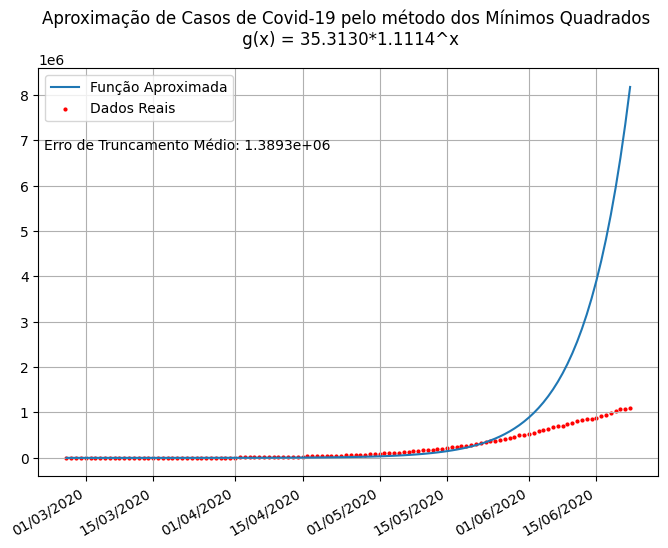

In [16]:
# Lineariza-se os dados e realiza-se o cálculo dos mínimos quadrados
b, a = mmq(x, np.log(y), 2)
a = np.exp(a)
b = np.exp(b)

fMmq = np.vectorize(lambda x: a * np.power(b,x))

yMmq = fMmq(x)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(xDays,yMmq, label='Função Aproximada')
ax.scatter(xDays,y, color='red', label='Dados Reais', s=4)

plt.title(f'Aproximação de Casos de Covid-19 pelo método dos Mínimos Quadrados \n g(x) = {a:.4f}*{b:.4f}^x')
plt.legend()

yErr = np.sqrt(np.mean((yMmq - y)**2))

plt.text(0.01, 0.8, f"Erro de Truncamento Médio: {yErr:.4e}", transform=plt.gca().transAxes)

ax.xaxis.set_major_formatter(dateFmtr)

plt.gcf().autofmt_xdate()

plt.grid(True)

plt.show()

### c)

Repita o item b) usando apenas os 20 primeiros dias.

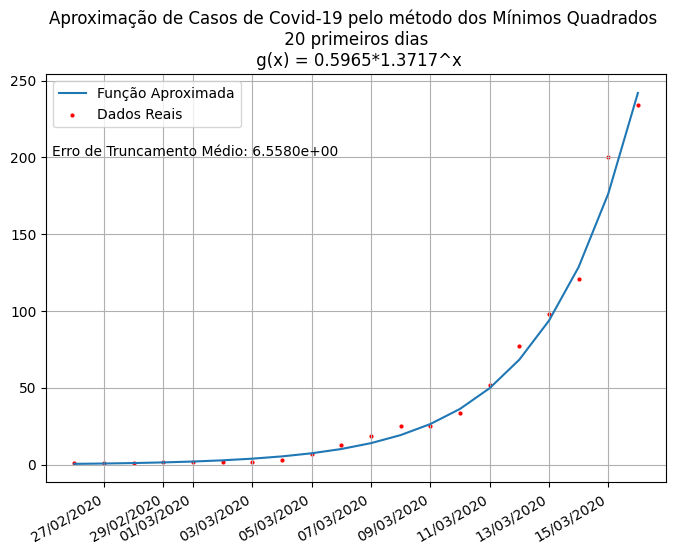

In [17]:
# Lineariza-se os dados e realiza-se o cálculo dos mínimos quadrados
b, a = mmq(x[:20], np.log(y[:20]), 2)
a = np.exp(a)
b = np.exp(b)

fMmq = np.vectorize(lambda x: a * np.power(b,x))

yMmq = fMmq(x[:20])

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(xDays[:20],yMmq, label='Função Aproximada')
ax.scatter(xDays[:20],y[:20], color='red', label='Dados Reais', s=4)

plt.title(f'Aproximação de Casos de Covid-19 pelo método dos Mínimos Quadrados \n 20 primeiros dias \n g(x) = {a:.4f}*{b:.4f}^x')
plt.legend()

yErr = np.sqrt(np.mean((yMmq - y[:20])**2))

plt.text(0.01, 0.8, f"Erro de Truncamento Médio: {yErr:.4e}", transform=plt.gca().transAxes)

ax.xaxis.set_major_formatter(dateFmtr)

plt.gcf().autofmt_xdate()

plt.grid(True)

plt.show()

### d)

Repita o item b) usando apenas os 50 últimos dias.

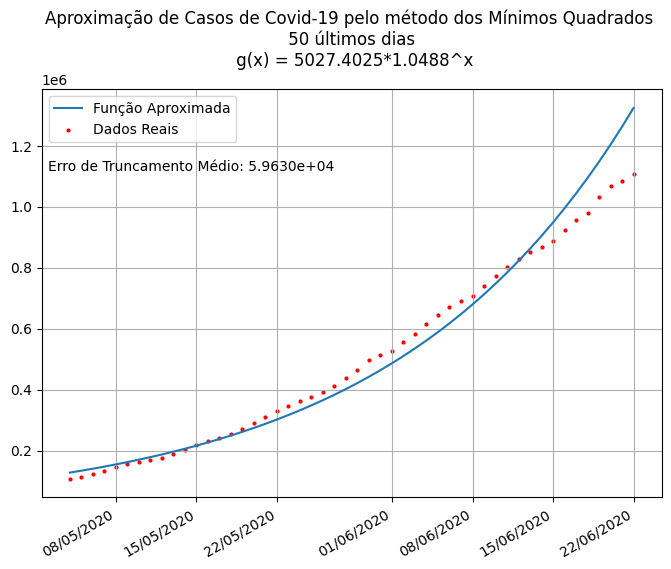

In [18]:
# Lineariza-se os dados e realiza-se o cálculo dos mínimos quadrados
b, a = mmq(x[-50:], np.log(y[-50:]), 2)
a = np.exp(a)
b = np.exp(b)

fMmq = np.vectorize(lambda x: a * np.power(b,x))

yMmq = fMmq(x[-50:])

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(xDays[-50:],yMmq, label='Função Aproximada')
ax.scatter(xDays[-50:],y[-50:], color='red', label='Dados Reais', s=4)

plt.title(f'Aproximação de Casos de Covid-19 pelo método dos Mínimos Quadrados \n 50 últimos dias \n g(x) = {a:.4f}*{b:.4f}^x')
plt.legend()

yErr = np.sqrt(np.mean((yMmq - y[-50:])**2))

plt.text(0.01, 0.8, f"Erro de Truncamento Médio: {yErr:.4e}", transform=plt.gca().transAxes)

ax.xaxis.set_major_formatter(dateFmtr)

plt.gcf().autofmt_xdate()

plt.grid(True)

plt.show()

### e)
Compare os itens b), c) e d). Que tipo de informação os dados nos fornecem ?

O item b) mostra que aproximar a curva de crescimento de casos de Covid-19 por uma curva $ab^x$ de base $b$ fixa (taxa de crescimento da função fixa) produz uma aproximação com grande erro. Tal problema advêm do fato de que a taxa de crescimento de casos não é fixa durante todo o período. Também é possível observar que a taxa de crescimento média de casos em todo o perído é $≈1.11$.

O item c) mostra que durante o início da pandemia (20 primeiros dias) a taxa de crescimento média de casos era de $≈1.37$. Também é possível observar que o valor de $a$ (valor inicial da função) é bem baixo, pois inicialmente haviam poucos casos.

O item d) mostra que durante o fim do período analisado (50 últimos dias) a taxa de crescimento média de casos era de $≈1.04$. Também é possível observar que o valor de $a$ (valor inicial da função) é bem alto, pois já haviam muitos casos.

Ao observar ambos os items c) e d) é possível notar que aproximações das curvas de crescimento para períodos mais curtos são mais acuradas.

Mais importante ainda é possível notar que a taxa de crescimento de casos no início da pandemia é consideravelmente maior do que nos últimos 50 dias analisados, tal fato provavelmente ocorre devido à implantação de medidas de isolamento social que visam diminuir a taxa de transmição da doença.